In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import warnings
import xarray as xr
from utils.evaluation import plot_predictions,plot_anomaly,plot_histogram,calc_peak,calc_mean
from utils.metrics import calculate_crps
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

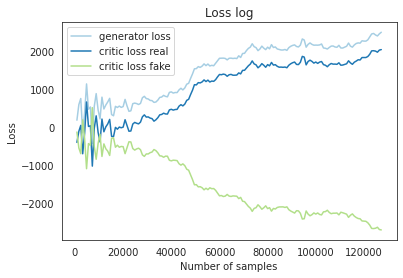

In [2]:
loss_log = pd.read_csv('/user/home/al18709/work/cgan/logs/log.txt', sep=",", header=None)[1:]
loss_log.columns = ['training_samples','disc_loss','disc_loss_real','disc_loss_fake','disc_loss_gp','gen_loss']
loss_log['training_samples'] = pd.to_numeric(loss_log['training_samples'],errors='coerce')
loss_log['gen_loss'] = pd.to_numeric(loss_log['gen_loss'],errors='coerce')
loss_log['disc_loss'] = pd.to_numeric(loss_log['disc_loss'],errors='coerce')
loss_log['disc_loss_real'] = pd.to_numeric(loss_log['disc_loss_real'],errors='coerce')
loss_log['disc_loss_fake'] = pd.to_numeric(loss_log['disc_loss_fake'],errors='coerce')


plt.plot(loss_log['training_samples'],loss_log['gen_loss'])
plt.plot(loss_log['training_samples'],loss_log['disc_loss_real'])
plt.plot(loss_log['training_samples'],loss_log['disc_loss_fake'])
plt.legend(labels=['generator loss','critic loss real','critic loss fake'])
plt.title('Loss log')
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.savefig('figs/loss_log.png',bbox_inches='tight')


show


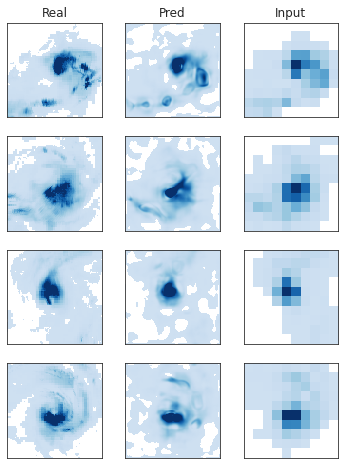

In [3]:
# set mode
mode = 'validation'

# load datasets
real = np.load('/user/home/al18709/work/cgan_predictions/%s_real.npy' % mode)[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/cgan_predictions/%s_pred.npy' % mode)[0][:,:,:,0]
inputs = np.load('/user/home/al18709/work/cgan_predictions/%s_input.npy' % mode)[0][:,:,:,0]

plot_predictions(real,pred,inputs,plot='show')


(2400, 100, 100)
(2400, 10, 10)
(10, 10)


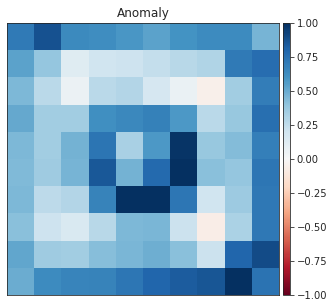

In [4]:

# calculate conservative error
print(pred.shape)

grid_in = xr.Dataset({'longitude': np.linspace(0, 100, 100),
			'latitude': np.linspace(-50, 50, 100)
			})
	# output grid has a the same coverage at finer resolution
grid_out = xr.Dataset({'longitude': np.linspace(0, 100, 10),
				'latitude': np.linspace(-50, 50, 10)
			})

regridder = xe.Regridder(grid_in, grid_out, 'conservative')

n_images,_,_ = pred.shape

tc = np.zeros((n_images,10,10))
anomalies = np.zeros((n_images,10,10))
all_rmse = np.zeros((n_images))
for i in range(n_images):
# for i in [0]:
	tc[i,:,:] = regridder(pred[i,:,:])
	rmse = np.sqrt(np.nanmean(((inputs[i,:,:]- tc[i,:,:]) ** 2)))
	anomaly = inputs[i,:,:] - tc[i,:,:]
	anomalies[i] = anomaly
	all_rmse[i] = rmse 

print(anomalies.shape)
anomalies_mean = np.nanmean(anomalies,axis=0)
print(anomalies_mean.shape)
plot_anomaly(anomalies_mean,plot='show',cmap='RdBu')



(2400,)
(2400,)
[34.125  73.5625 44.25   ... 38.4375 70.1875 61.875 ]


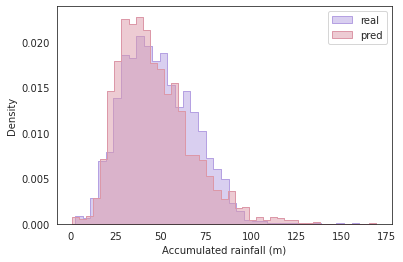

(2400,)
(2400,)
[3.12692618 2.6954362  4.03542664 ... 4.27281313 3.88184689 4.23878487]


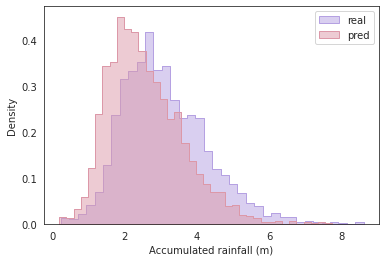

In [5]:
# Plot peak railfall distributions

peak_reals = calc_peak(real)
peak_preds = calc_peak(pred)

print(peak_reals.shape)
print(peak_preds.shape)
print(peak_reals)
plot_histogram(peak_reals,peak_preds,5,0.5)

mean_reals = calc_mean(real)
mean_preds = calc_mean(pred)

print(mean_reals.shape)
print(mean_preds.shape)
print(mean_reals)
plot_histogram(mean_reals,mean_preds,5,0.5)


(2400, 100, 100)


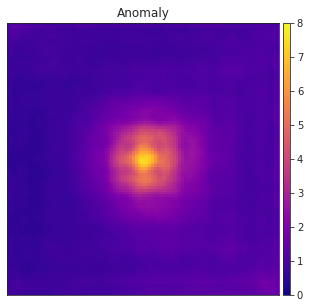

1.4237949914921235


In [6]:
# Calculate CRPS
crps = calculate_crps(real,pred)
print(crps.shape)
plot_anomaly(np.nanmean(crps,axis=0),vmin=0,vmax=8,plot='show',cmap='plasma')
print(np.nanmean(crps))